In [1]:
from qiskit import *
import copy
import matplotlib as mpl
import math
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# imported packages for the project

In [2]:
# You can think of this entire section as the 'classical position mapping' equivalent, there is nothing quantum 
# or ai here, this is purely classical code that sets up and prepares our information.
#
# The core mechanisms works by defining a 4 by 4 chess board, where each square is designated 0 or 1, where 0 
# means not attacked, and 1 means attacked. We will attempt to find any possible mates given any position consisting
# of a white king, white queen, and black king. 
#
# 4 by 4 board, 0-3 top down, 0-3 left right.
# Classical Setup to intialize the board in preparation of applying Grovers Algorithm.
# Init creates an initial Quantum circuit, finds all the squares the king attacks, and sets them to 1
# Since this is a 4 by 4 board, there are a lot of edge cases, hence the massive amount of if statements.
def Init(WK):
    qc = QuantumCircuit(17, 16)
    test = [0]*16;
    List = [];
    if (WK[0] == 0 and WK[1] == 0):
        attacked = [[0,0],[0,1],[1,0],[1,1]]
    elif (WK[0] == 3 and WK[1] == 0):
        attacked = [[3,0],[3,1],[2,0],[2,1]]
    elif (WK[0] == 3 and WK[1] == 3):
        attacked = [[3,3],[3,2],[2,3],[2,2]]
    elif (WK[0] == 0 and WK[1] == 3):
        attacked = [[0,3],[1,3],[0,2],[1,2]]
    elif (WK[0] == 0):
        attacked = [[WK[0], WK[1]-1],[WK[0],WK[1]],[WK[0],WK[1]+1],
                    [WK[0]+1, WK[1]-1],[WK[0]+1,WK[1]],[WK[0]+1,WK[1]+1]]
    elif (WK[0] == 3):
        attacked = [[WK[0], WK[1]-1],[WK[0],WK[1]],[WK[0],WK[1]+1],
                    [WK[0]-1, WK[1]-1],[WK[0]-1,WK[1]],[WK[0]-1,WK[1]+1]]
    elif (WK[1] == 0):
        attacked = [[WK[0]-1, WK[1]],[WK[0],WK[1]],[WK[0]+1,WK[1]],
                    [WK[0]-1, WK[1]+1],[WK[0],WK[1]+1],[WK[0]+1,WK[1]+1]]
    elif (WK[1] == 3):
        attacked = [[WK[0]-1, WK[1]],[WK[0],WK[1]],[WK[0]+1,WK[1]],
                    [WK[0]-1, WK[1]-1],[WK[0],WK[1]-1],[WK[0]+1,WK[1]-1]]
    else:
        attacked = [[WK[0]+1,WK[1]-1],[WK[0]+1,WK[1]],[WK[0]+1,WK[1]+1],
                      [WK[0],WK[1]-1],[WK[0],WK[1]],[WK[0],WK[1]+1],
                      [WK[0]-1,WK[1]-1],[WK[0]-1,WK[1]],[WK[0]-1,WK[1]+1]]
    for i in range(len(attacked)):
        test[4*attacked[i][0]+attacked[i][1]] = 1;
        qc.x(4*attacked[i][0]+attacked[i][1]);
        qc.h(4*attacked[i][0]+attacked[i][1]);
        List.append(4*attacked[i][0]+attacked[i][1]);
    return test, qc, List;
King = [2, 2] #White king position on the board
test1, qc, listtest = Init(King);
# Moveable determines all the squares the queen can potentially move to, 
# as well as all the squares the queen can attack from any given position.
def Moveable(Queen, testing, king):
    QueenMoves = []
    test = testing.copy();
    if (test[4*Queen[0]+Queen[1]] == 0):
            boolean = 1;
    else:
        boolean = 0;
    looper = [0, 1, 2, 3];
    for i in range(len(looper)):
        if (4*king[0]+king[1] == 4*looper[i]+Queen[1]):
            break;
        test[4*looper[i]+Queen[1]] = 1;
        QueenMoves.append([i, Queen[1]])
    for i in range(len(looper)):
        if (4*king[0]+king[1] == 4*Queen[0]+looper[i]):
            break;
        test[4*Queen[0]+looper[i]] = 1;
        QueenMoves.append([Queen[0], i]);
    for i in range(len(looper)):
        if (Queen[0]+i < 4 and Queen[0]+i >=0 and Queen[1]-i < 4 and Queen[1]-i >= 0):
            test[4*(Queen[0]+i)+Queen[1]-i] = 1;
            QueenMoves.append([Queen[0]+i, Queen[1]-i]);
        if (Queen[0]-i < 4 and Queen[0]-i >=0 and Queen[1]+i < 4 and Queen[1]+i >= 0):
            test[4*(Queen[0]-i)+Queen[1]+i] = 1;
            QueenMoves.append([Queen[0]-i, Queen[1]+i]);
        if (Queen[0]+i < 4 and Queen[0]+i >=0 and Queen[1]+i < 4 and Queen[1]+i >= 0):
            test[4*(Queen[0]+i)+Queen[1]+i] = 1;
            QueenMoves.append([Queen[0]+i, Queen[1]+i]);
        if (Queen[0]-i < 4 and Queen[0]-i >=0 and Queen[1]-i < 4 and Queen[1]-i >= 0):
            test[4*(Queen[0]-i)+Queen[1]-i] = 1;
            QueenMoves.append([Queen[0]-i, Queen[1]-i]);
        if (boolean == 1):
            test[4*Queen[0]+Queen[1]] = 0;
    return test, QueenMoves;
QueenSpot = [1, 1]; #White queen position on the board
test3, QueenMoves = Moveable(QueenSpot, test1, King);
test4 = np.reshape(test3, (4, 4));
print(test4)
# Checkmate finds all the squares that need to be attacked for a checkmate condition to be met.
# This checkmate condition is then used in the 'oracle' part of the quantum circuit later on.
# For our current project, this condition is changed to be our POSITION VALUE FUNCTION, this is one the main
# differences, as we are swapping from a concrete binary decision, which is easy to implement, to a more dynamic
# function, which is much harder.
def Checkmate(BK):
    test = [0]*16;
    counter = 0;
    if (BK[0] == 0 and BK[1] == 0):
        attacked = [[0,0],[0,1],[1,0],[1,1]]
        holder = 0
    elif (BK[0] == 3 and BK[1] == 0):
        attacked = [[3,0],[3,1],[2,0],[2,1]]
        holder = 0
    elif (BK[0] == 3 and BK[1] == 3):
        attacked = [[3,3],[3,2],[2,3],[2,2]]
        holder = 0
    elif (BK[0] == 0 and BK[1] == 3):
        attacked = [[0,3],[1,3],[0,2],[1,2]]
        holder = 0
    elif (BK[0] == 0):
        attacked = [[BK[0], BK[1]-1],[BK[0],BK[1]],[BK[0],BK[1]+1],
                    [BK[0]+1, BK[1]-1],[BK[0]+1,BK[1]],[BK[0]+1,BK[1]+1]]
        holder = 1;
    elif (BK[0] == 3):
        attacked = [[BK[0], BK[1]-1],[BK[0],BK[1]],[BK[0],BK[1]+1],
                    [BK[0]-1, BK[1]-1],[BK[0]-1,BK[1]],[BK[0]-1,BK[1]+1]]
        holder = 1;
    elif (BK[1] == 0):
        attacked = [[BK[0]-1, BK[1]],[BK[0],BK[1]],[BK[0]+1,BK[1]],
                    [BK[0]-1, BK[1]+1],[BK[0],BK[1]+1],[BK[0]+1,BK[1]+1]]
        holder = 1;
    elif (BK[1] == 3):
        attacked = [[BK[0]-1, BK[1]],[BK[0],BK[1]],[BK[0]+1,BK[1]],
                    [BK[0]-1, BK[1]-1],[BK[0],BK[1]-1],[BK[0]+1,BK[1]-1]]
        holder = 1;
    else:
        attacked = [[BK[0]+1,BK[1]-1],[BK[0]+1,BK[1]],[BK[0]+1,BK[1]+1],
                      [BK[0],BK[1]-1],[BK[0],BK[1]],[BK[0],BK[1]+1],
                      [BK[0]-1,BK[1]-1],[BK[0]-1,BK[1]],[BK[0]-1,BK[1]+1]]
        holder = 2;
    if (holder == 0):
        ret = [0]*4
    elif(holder == 1):
        ret = [0]*6
    else:
        ret = [0]*9
    for i in range(len(attacked)):
        test[4*attacked[i][0]+attacked[i][1]] = 1;
    for n in range(len(test)):
        if (test[n] == 1):
            ret[counter]=n;
            counter = counter + 1;
    return ret;
# The following code reduces our runtime, by essentially removing all qubits that are guaranteed
# to  be 1, and reducing the amount of qubits our circuit needs on a case by case basis.
# This is optimization, so you don't necessarily have to think about this part
clause_qubits = Checkmate([0, 3]); #Bit awkard here, but the [0, 3] here represents the black king position.
initiallist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for element in initiallist:
    if element in listtest:
        initiallist.remove(element)
for element in clause_qubits:
    if element in listtest:
        clause_qubits.remove(element)
# Here we create a library of all legal queen moves from the given starting position, we later
# cross check this with our results to obtain our final result. It is worth noting that this algorithm might also 
# evaluate positions which arent physically reachable, and so this is a nice way of filtering those out.
def library(QueenMoves):
    List = [];
    for n in range(len(QueenMoves)):
        Position, trash = Moveable(QueenMoves[n], test1, King);
        List.append(Position);
    return List;
PotentialPositions = library(QueenMoves);
Listing = [];
for n in range(len(PotentialPositions)):
    Hold = ''.join(str(PotentialPositions[n]).split(', '));
    Hold1 = ''.join(str(Hold).split('['));
    Hold2 = ''.join(str(Hold1).split(']'));
    Listing.append(Hold2);
print(Listing)

[[1 1 1 0]
 [1 1 1 1]
 [1 1 1 1]
 [0 1 1 1]]
['1011111101110111', '1110111111110111', '0101111111111111', '0100011111111111', '1100011111111111', '1110111111110111', '0111111101111111', '0011111101110111', '1110111111110111', '1110111111110111', '1110111111110111', '1110111111110111', '1010111101111111', '1101011111110111', '1010011111110111', '0111111111111111', '1001011101111111']


In [3]:
# From here on out, we create our quantum circuit. This is a bit difficult to understand so be careful.
# We apply a universal hadamard to intialize our circuit.
# What this does, is put our board in a complete superposition, so that it is in every single possible
# permutation at the same time with equal probability. As there are 16 squares on a 4 by 4 board, it is evaluating
# 2^16 configurations, though this is partially reduced by earlier optional optimization code.
qc.h([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
qc.x(16)
qc.h(16)

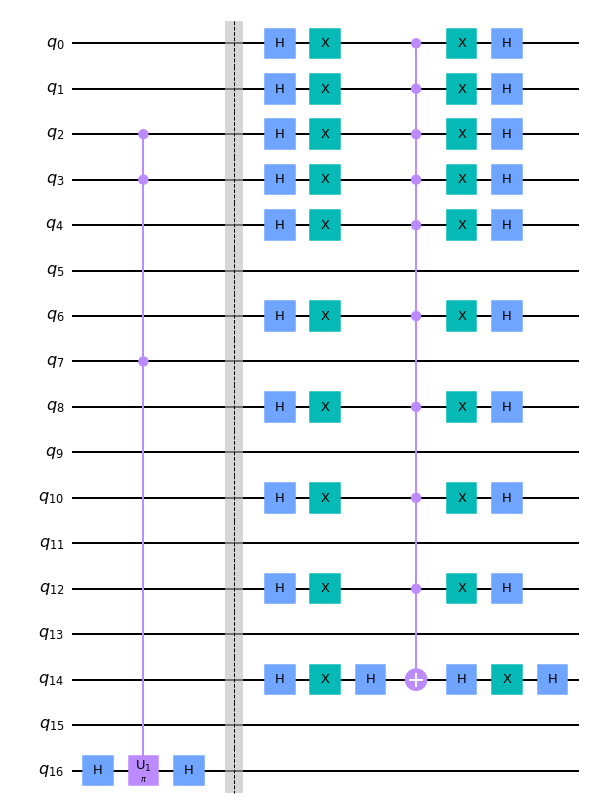

In [4]:
# Here we create the diffuser and oracle, the oracle is from our checkmate condition, which returned the squares that
# needed to be attacked for checkmate to happen. The oracle marks any positions that satisfy this condition.
# We then make this into a gate so that we can apply as many times as necessary
# Note, the oracle is simply the mct gate in the bottom fo this code block.
#
# The diffuser is a bit more complicated to explain, conceptually, what it does is a 'phase kickback', which 
# means it takes the marked states, and enhances their probabilities so that the marked positions have a higher
# chance of being measured. And so- finding the positions that result in a checkmate.
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s
qc1 = QuantumCircuit(17);
qc1.mct(clause_qubits, 16)
qc1.barrier()
diff = diffuser(len(initiallist))
qc1.append(diff,initiallist)
qc1.decompose().draw(output = 'mpl')
#qc1.to_gate()


In [5]:
count = 0
n = 2**7;
m = 2**5;
# Here we calculate m and n so we know how many times our circuit should be ran for optimal results. This is since
# our runtime is not O(1), but (0sqrt(N)), and then run it that many times.
while (count <= (math.pi/4)*math.sqrt(n/m)):
    count = count + 1
    qc.append(qc1,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [6]:
# Here we measure the resulting qubit states
qc.measure([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [7]:
# We execute our circuit and find the grover solutions, via IBMs quantum simulator.
# Note that all the results are 16 numbers,and you can reformat this in your head so it is 4 by 4 instead, with 1s
# being attacked, and 0s being safe. At first this seems like a massive amount of possible solutions, but we
# have already cut down our original number 2^16 a lot. Furthermore, some of these positions are not physically 
# reachable, which is why we now cross check with our intial queen move library created in code block 1.
backend = Aer.get_backend('qasm_simulator')
job=execute(qc, backend, shots = 10000)
result1 = job.result()
counts3 = result1.get_counts()
counts4 = {c:counts3[c] for c in counts3 if counts3[c] > 0}
N = 2**5;
res = dict(sorted(counts4.items(), key = itemgetter(1), reverse = True)[:N])
groversitems = list(dict.keys(res));
groversitems


['1110111111101110',
 '1110111111101111',
 '1111111011111111',
 '1110111111111111',
 '1111111011111101',
 '1111111111101111',
 '1110111011111110',
 '1111111111111101',
 '1110111011111111',
 '1110111011101111',
 '1110111011101100',
 '1110111011111101',
 '1110111111111101',
 '1111111111111100',
 '1111111011101111',
 '1110111111101100',
 '1110111011101110',
 '1111111011111110',
 '1111111111111110',
 '1111111011101110',
 '1110111111101101',
 '1110111111111100',
 '1110111011111100',
 '1111111011101100',
 '1110111011101101',
 '1110111111111110',
 '1111111111101110',
 '1111111111111111',
 '1111111111101100',
 '1111111011101101',
 '1111111011111100',
 '1110111011110101']

In [8]:
# Due to how the circuit is outputed, we have to reverse every string from the grovers solutions,
# we then cross check it with our legal queen move library created initially to find our final
# checkmates.
grovers = [];
for element in groversitems:
    stringlength=len(element) # calculate length of the list
    slicedString=element[stringlength::-1] # slicing
    grovers.append(slicedString);
final = list(set(grovers) & set(Listing));

QueenMates = [];
for n in range(len(Listing)):
    if Listing[n] in final:
        QueenMates.append(QueenMoves[n])
print(final)
# We print the square the queen needs to move to in order to deliver checkmate
print(QueenMates)



['0111111111111111', '1011111101110111', '0011111101110111', '0111111101111111']
[[0, 1], [1, 2], [1, 3], [0, 0]]
